# Hierarchical Bayesian Neural Networks

"Flaxified" version of the [`bnn_hierarchical.ipynb`](https://github.com/probml/pyprobml/blob/master/notebooks/book2/17/bnn_hierarchical.ipynb) notebook. The implementation of this HBNN is model-indendent, as long as the model is specified as a Flax model.

In [ ]:
try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq jaxopt
    %pip install -qq blackjax
    import blackjax

try:
    import distrax
except ModuleNotFoundError:
    %pip install -qq distrax
    import distrax

try:
    import flax
except ModuleNotFoundError:
    %pip install -qq distrax
    import flax

try:
    import tensorflow_probability.substrates.jax.distributions as tfd
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    import tensorflow_probability.substrates.jax.distributions as tfd

In [71]:
import jax
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix
from jax.flatten_util import ravel_pytree

In [2]:
HalfNormal = distrax.as_distribution(tfd.HalfNormal(1.0))

In [3]:
%config InlineBackend.figure_format = "retina"
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)

In [41]:
def rotation_matrix(angle):
    """
    Create a rotation matrix that rotates the
    space 'angle'-radians.
    """
    R = jnp.array([[jnp.cos(angle), -jnp.sin(angle)], [jnp.sin(angle), jnp.cos(angle)]])
    return R


def make_rotating_moons(radians, n_samples=100, **kwargs):
    """
    Make two interleaving half circles rotated by 'radians' radians

    Parameters
    ----------
    radians: float
        Angle of rotation
    n_samples: int
        Number of samples
    **kwargs:
        Extra arguments passed to the `make_moons` function
    """
    X, y = make_moons(n_samples=n_samples, **kwargs)
    X = jnp.einsum("nm,mk->nk", X, rotation_matrix(radians))
    return X, y


def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

## Hierarchical model

We consider a hierarchical model which has a common Gaussian prior for all the weights, but allows each task to have its own task-specific parameters. More precisely, let $w^{t}_{ijl}\sim\mathcal{N}(\mu_{ijl}, 0)$ be the weight for node $i$ to node $j$ in layer $l$ at task $t$. We assume

$$
\begin{aligned}
    \sigma_l &\sim \mathcal{N}^+(0,1)\\
    \mu_{ijl} &\sim \mathcal{N}(0, 1)\\
    \varepsilon^t_{ijl} &\sim \mathcal{N}(0, 1)\\
    w^t_{ijl} &\sim \mathcal{N}(\mu_{ijl}, \sigma_l)
\end{aligned}
$$

Or, in non-centred form,

$$
    w^t_{ijl} = \mu_{ijl} + \varepsilon^t_{ijl} \sigma_l
$$

In [30]:
def get_num_layers(params):
    """
    Obtain the number of layers given a set
    of params of a Flax model
    """
    num_layers = len((jax.tree_flatten(params, lambda x: "params" not in x))[0][0])
    return num_layers


def init_hbnn_params(key, model, batch, n_tasks):
    """
    Initialise the parameters of the Hierarchical Bayesian Neural Network
    """
    key_tasks_init, key_params_init, key_sigma_init = jax.random.split(key, 3)
    keys_tasks_init = jax.random.split(key_tasks_init, n_tasks)

    params_tasks = jax.vmap(model.init, (0, None))(keys_tasks_init, batch)
    params_shared = model.init(key_params_init, batch)
    n_layers = get_num_layers(params_shared)
    params_sigma = HalfNormal.sample(seed=key_sigma_init, sample_shape=(n_layers,))

    model_treedef = jax.tree_structure(params_shared)

    params_init = {
        "task": params_tasks,
        "noise": params_sigma,
        "shared": params_shared,
    }

    return params_init, model_treedef


def build_sigma_tree(params, treedef, n_layers):
    """
    Build a tree of parameters that satisfy
    the HBNN conditions and is flax-compatible
    """
    map_array = jnp.ones((1, 1, n_layers, 2))
    params_sigma_tree = jnp.einsum("k,ijkl->ijkl", params, map_array)
    params_sigma_tree = jax.tree_util.build_tree(treedef, params_sigma_tree)
    return params_sigma_tree


@partial(jax.vmap, in_axes=0)
def vmap_log_likelihood(params, X, y):
    """
    Hierarchical Bayesian neural network log-likelihood

    Parameters
    ----------
    params: pytree
    X: jnp.array(C, N, ...)
        Collection of observations
    y: jnp.array(C, N, ...)
        Collection of outputs
    """
    logits = model.apply(params, X).ravel()
    log_likelihood = distrax.Bernoulli(logits=logits).log_prob(y).sum()
    return log_likelihood


def hierarchical_bnn_log_joint(params, X, y, model):
    """
    Hierarchical Bayesian neural network log-joint. The model
    assumes

    w^t_{ijl} = \mu_{ijl} + \varepsilon^t_{ijl} \sigma_l

    Parameters
    ----------
    parameters: flax.FrozenDict
    X: jnp.array(C, N, ...)
        Collection of observations
    y: jnp.array(C, N, ...)
        Collection of outputs

    Returns
    -------
    float: float
        Log-joint value
    """

    n_layers = get_num_layers(params["shared"])
    shared_tree = params["shared"]
    task_tree = params["task"]
    sigma_tree = build_sigma_tree(params["noise"], model_treedef, n_layers)

    model_params = jax.tree_map(lambda mu, task, sigma: mu + sigma * task, shared_tree, task_tree, sigma_tree)

    # ** log-likelihood for all tasks **
    log_likelihood_collection = vmap_log_likelihood(model_params, X, y).sum()

    # ** log priors **
    # Tasks priors
    log_task_prior = jax.tree_map(distrax.Normal(0, 1).log_prob, task_tree)
    log_task_prior = ravel_pytree(log_task_prior)[0].sum()
    # Global prior
    log_shared_prior = jax.tree_map(distrax.Normal(0, 1).log_prob, shared_tree)
    log_shared_prior = ravel_pytree(log_shared_prior)[0].sum()
    # Sigma-layered prior
    log_sigma_prior = HalfNormal.log_prob(params["noise"]).sum()

    log_prior = log_task_prior + log_shared_prior + log_sigma_prior
    log_joint = log_likelihood_collection + log_prior
    return log_joint


def build_model_params(params, treedef, n_layers):
    """
    Aggregate dictionary of parameters into a
    Flax-valid set of parameters.

    Parameters
    ----------
    params: dict
        Colletion of parameters for the HBNN as
        specified by `init_hbnn_params`

    Returns
    -------
    flax.FrozenDict: flax-compatible set of weights
    """
    shared_tree = params["shared"]
    task_tree = params["task"]
    sigma_tree = build_sigma_tree(params["noise"], treedef, n_layers)

    model_params = jax.tree_map(lambda mu, task, sigma: mu + sigma * task, shared_tree, task_tree, sigma_tree)
    return model_params


@partial(jax.vmap, in_axes=(0, None, None))
def eval_hbnn_tasks(params, X, treedef):
    n_layers = get_num_layers(params["shared"])
    model_params = build_model_params(params, treedef, n_layers)
    return jax.vmap(model.apply, 0)(model_params, X)


@partial(jax.vmap, in_axes=(None, 2, None), out_axes=2)
@partial(jax.vmap, in_axes=(None, 1, None), out_axes=1)
@partial(jax.vmap, in_axes=(0, None, None), out_axes=0)
def eval_hbnn_grid(params, X, treedef):
    n_layers = get_num_layers(params["shared"])
    model_params = build_model_params(params, treedef, n_layers)
    return jax.vmap(model.apply, (0, None))(model_params, X)

In [10]:
key = jax.random.PRNGKey(314)
key_samples, key = jax.random.split(key)

## Create dataset

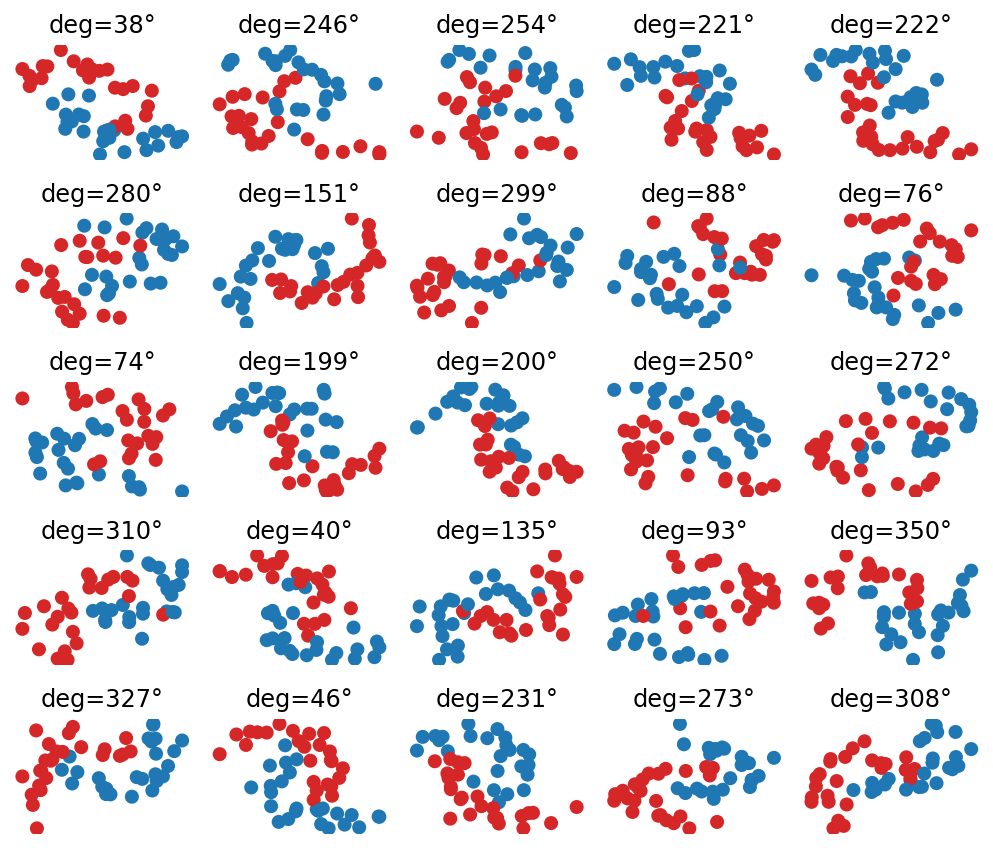

In [11]:
fig, ax = plt.subplots(5, 5, figsize=(7, 6))
ax = ax.ravel()

n_radians = 25
noise = 0.2
n_samples = 50
radians_rand = jax.random.uniform(key_samples, (n_radians,)) * 2 * jnp.pi

X_collection = []
y_collection = []

for axi, rad in zip(ax, radians_rand):
    X, y = make_rotating_moons(rad, n_samples, noise=noise)
    c = ["tab:blue" if yn == 1 else "tab:red" for yn in y]
    axi.scatter(*X.T, c=c)
    axi.axis("off")

    X_collection.append(X)
    y_collection.append(y)

    deg = rad * 180 / jnp.pi
    axi.set_title(f"{deg=:0.0f}°")
plt.tight_layout()

X_collection = jnp.stack(X_collection)
y_collection = jnp.stack(y_collection)

## Building model

In [13]:
key_model_init, key_state_init, key_sample = jax.random.split(key, 3)

In [42]:
class MLP(nn.Module):
    """
    Multi-layered perceptron for classificaton.
    """

    # num_outputs: int
    @nn.compact
    def __call__(self, x):
        x = nn.tanh(nn.Dense(6)(x))
        x = nn.tanh(nn.Dense(6)(x))
        x = nn.Dense(1)(x)
        return x


model = MLP()
batch = jnp.ones((n_samples, 2))
params_all, model_treedef = init_hbnn_params(key_model_init, model, batch, n_radians)

/home/gerardoduran/miniconda3/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:4403: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


CPU times: user 24.7 s, sys: 1.62 s, total: 26.4 s
Wall time: 4min 32s


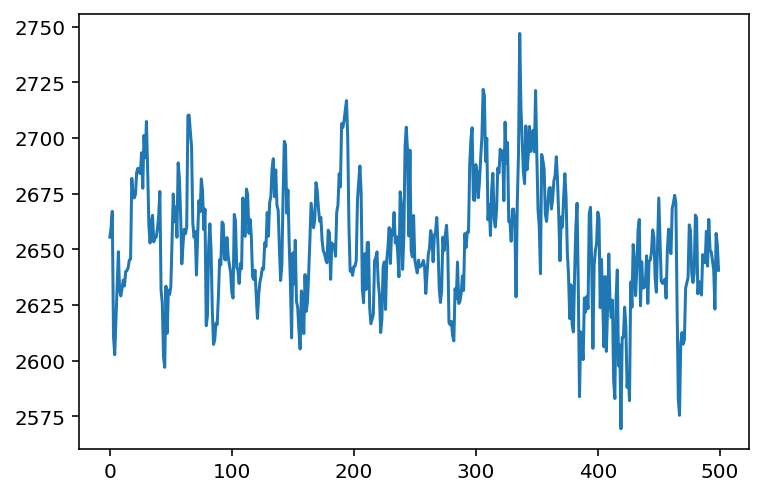

In [19]:
%%time
num_warmup = 3000
num_samples = 500

potential = partial(hierarchical_bnn_log_joint, X=X_collection, y=y_collection, model=model)

adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_state_init, params_all)

states = inference_loop(key_sample, kernel, final_state, num_samples)
sampled_params = states.position
plt.plot(states.potential_energy)

In [69]:
ix = 10
y_est = nn.sigmoid(logits).mean(axis=0)[..., 0][ix] > 0.5
confusion_matrix(y_collection[ix], y_est)

array([[25,  0],
       [ 0, 25]])

## Evaluating grid

In [70]:
step = 0.2
vmin, vmax = X_collection.min() - step, X_collection.max() + step
X_grid = jnp.mgrid[vmin:vmax:50j, vmin:vmax:50j]

logits_grid = eval_hbnn_grid(sampled_params, X_grid, model_treedef)

probs_grid = nn.sigmoid(logits_grid).mean(axis=0)[..., 0]

probs_grid_std = nn.sigmoid(logits_grid).std(axis=0)[..., 0]
probs_grid_std = jnp.einsum("nmk->knm", probs_grid_std)

probs_grid_sample = jax.random.bernoulli(key, p=probs_grid, shape=(100, 50, 50, 25)).mean(axis=0)
probs_grid_sample = jnp.einsum("nmk->knm", probs_grid_sample)

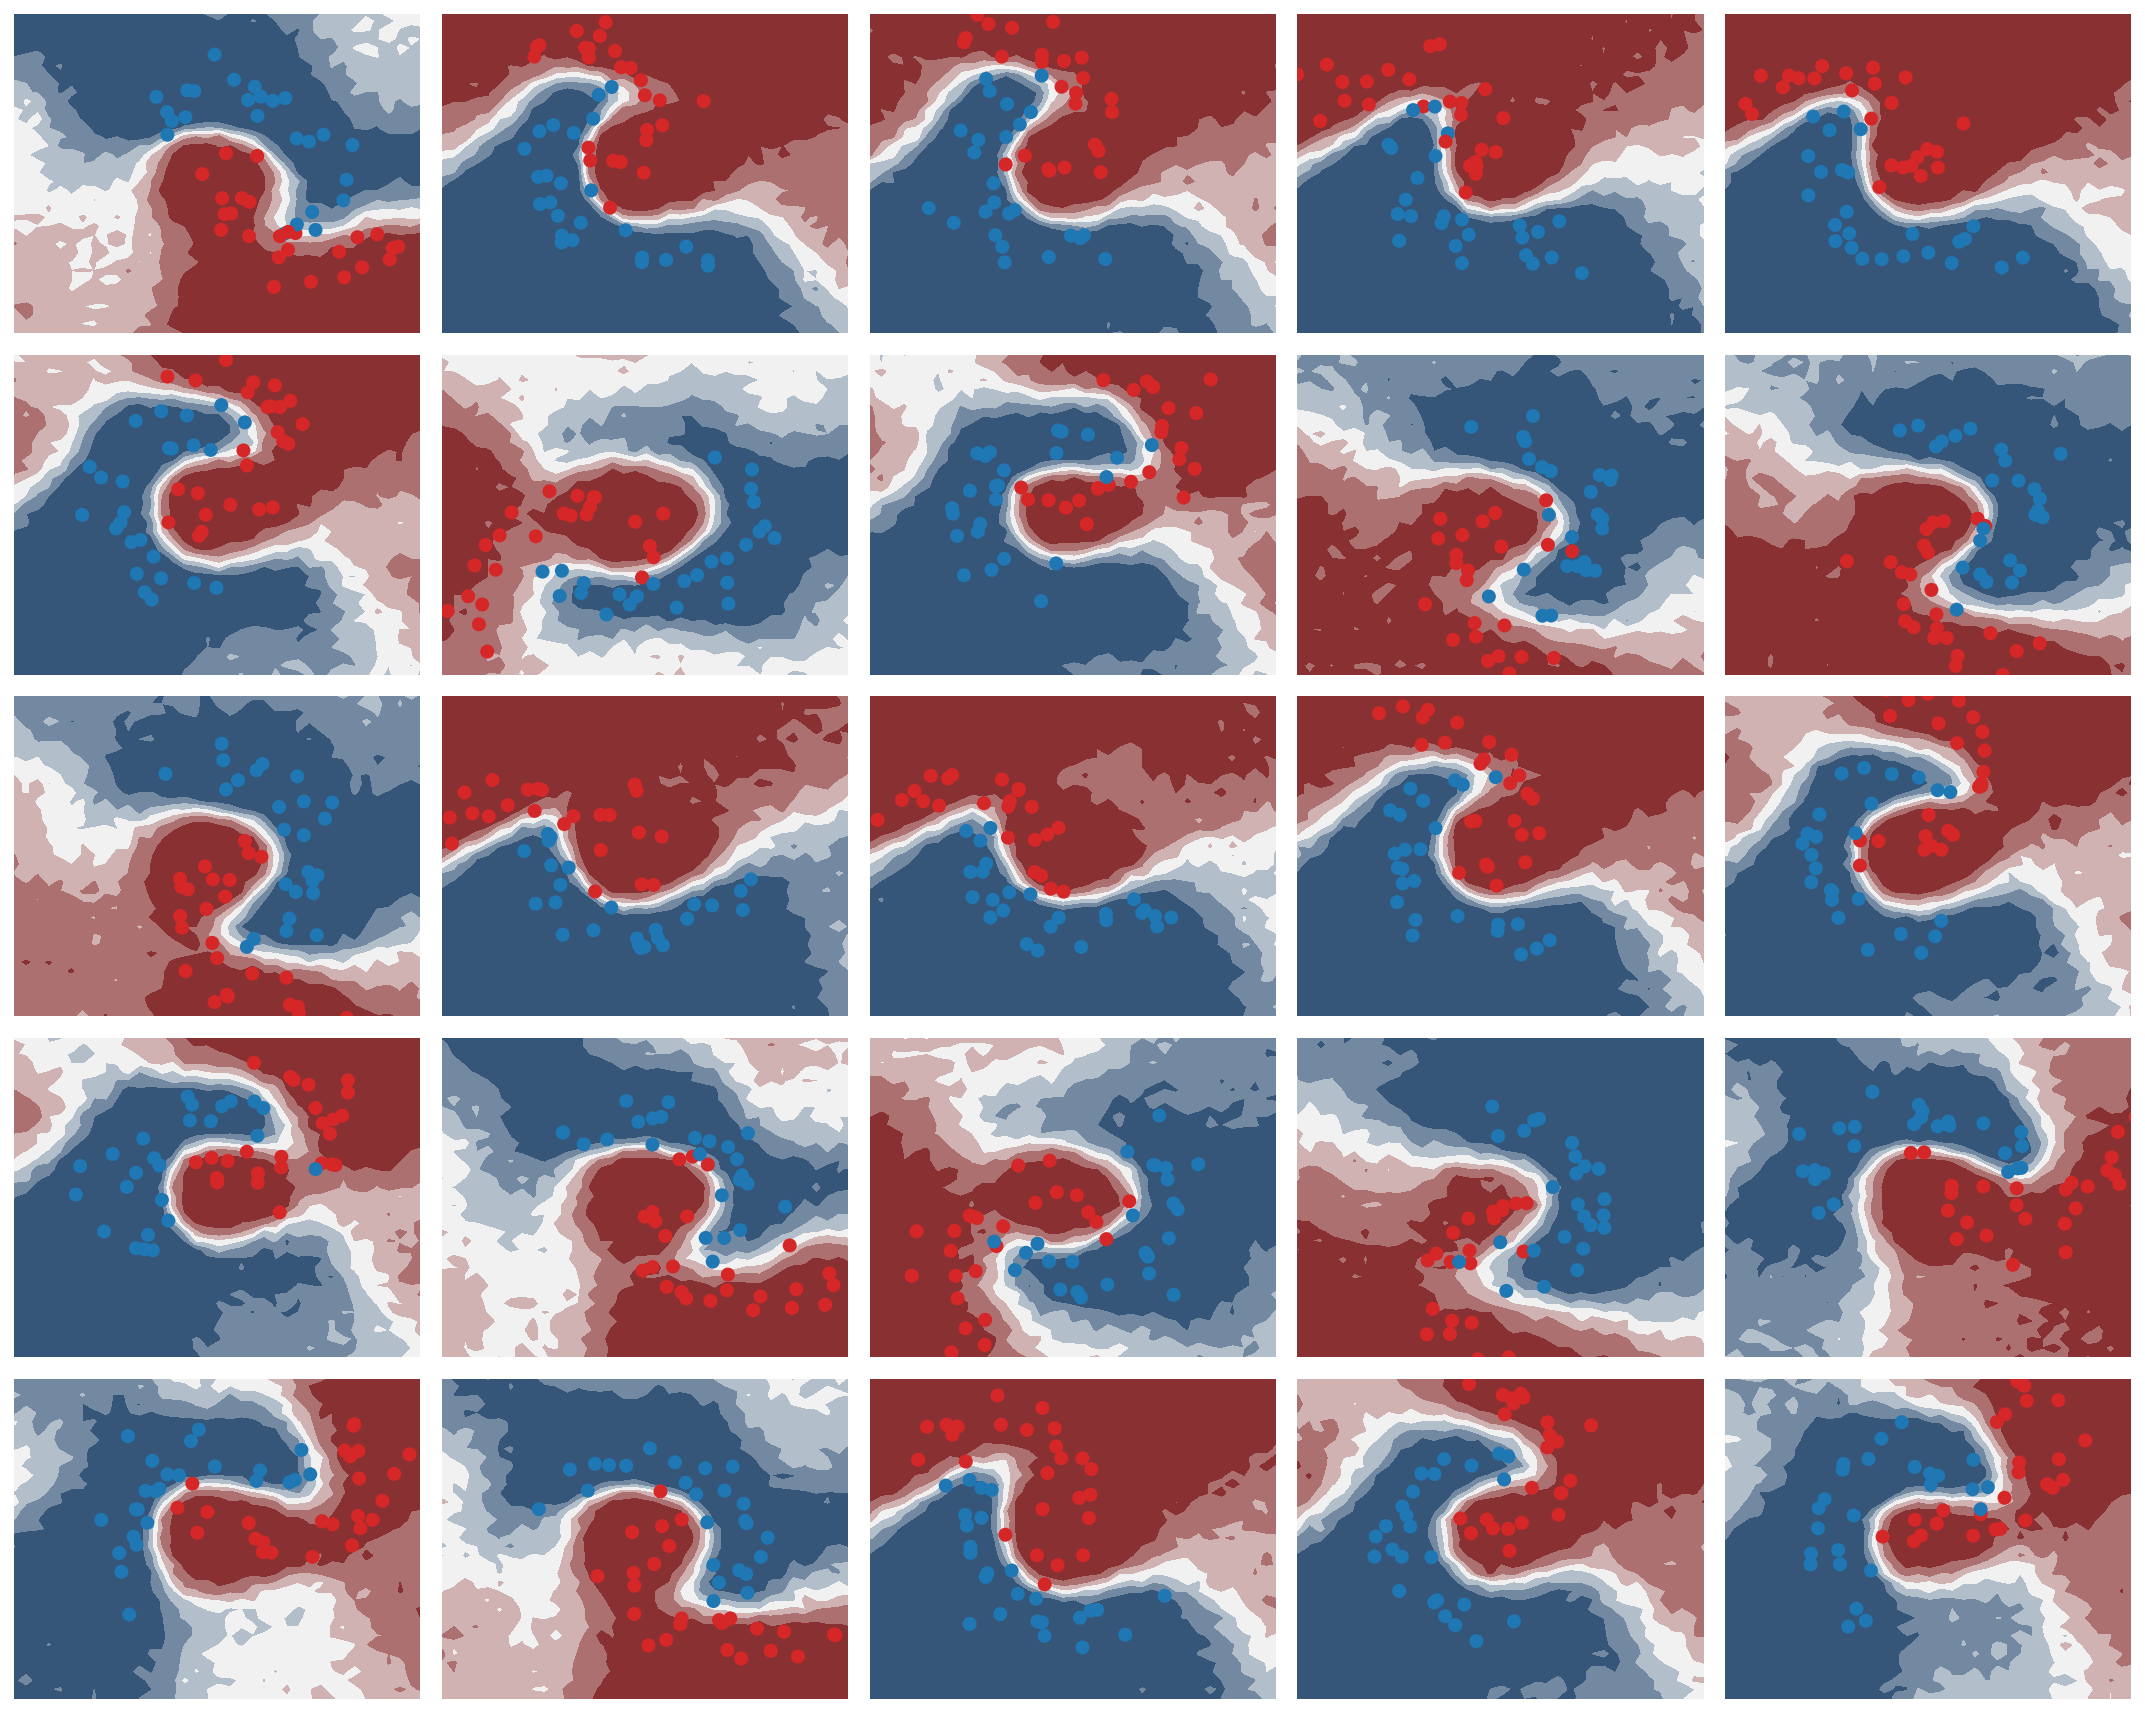

In [35]:
fig, ax = plt.subplots(5, 5, figsize=(15, 12))
for axi, pv, X, y in zip(ax.ravel(), probs_grid_sample, X_collection, y_collection):
    colors = ["tab:red" if yn == 1 else "tab:blue" for yn in y]
    axi.contourf(*X_grid, pv, zorder=0, cmap=cmap)
    axi.scatter(*X.T, c=colors, zorder=1)
    axi.axis("off")
    axi.set_xlim(-2, 2)
    axi.set_ylim(-2, 2)
plt.tight_layout()

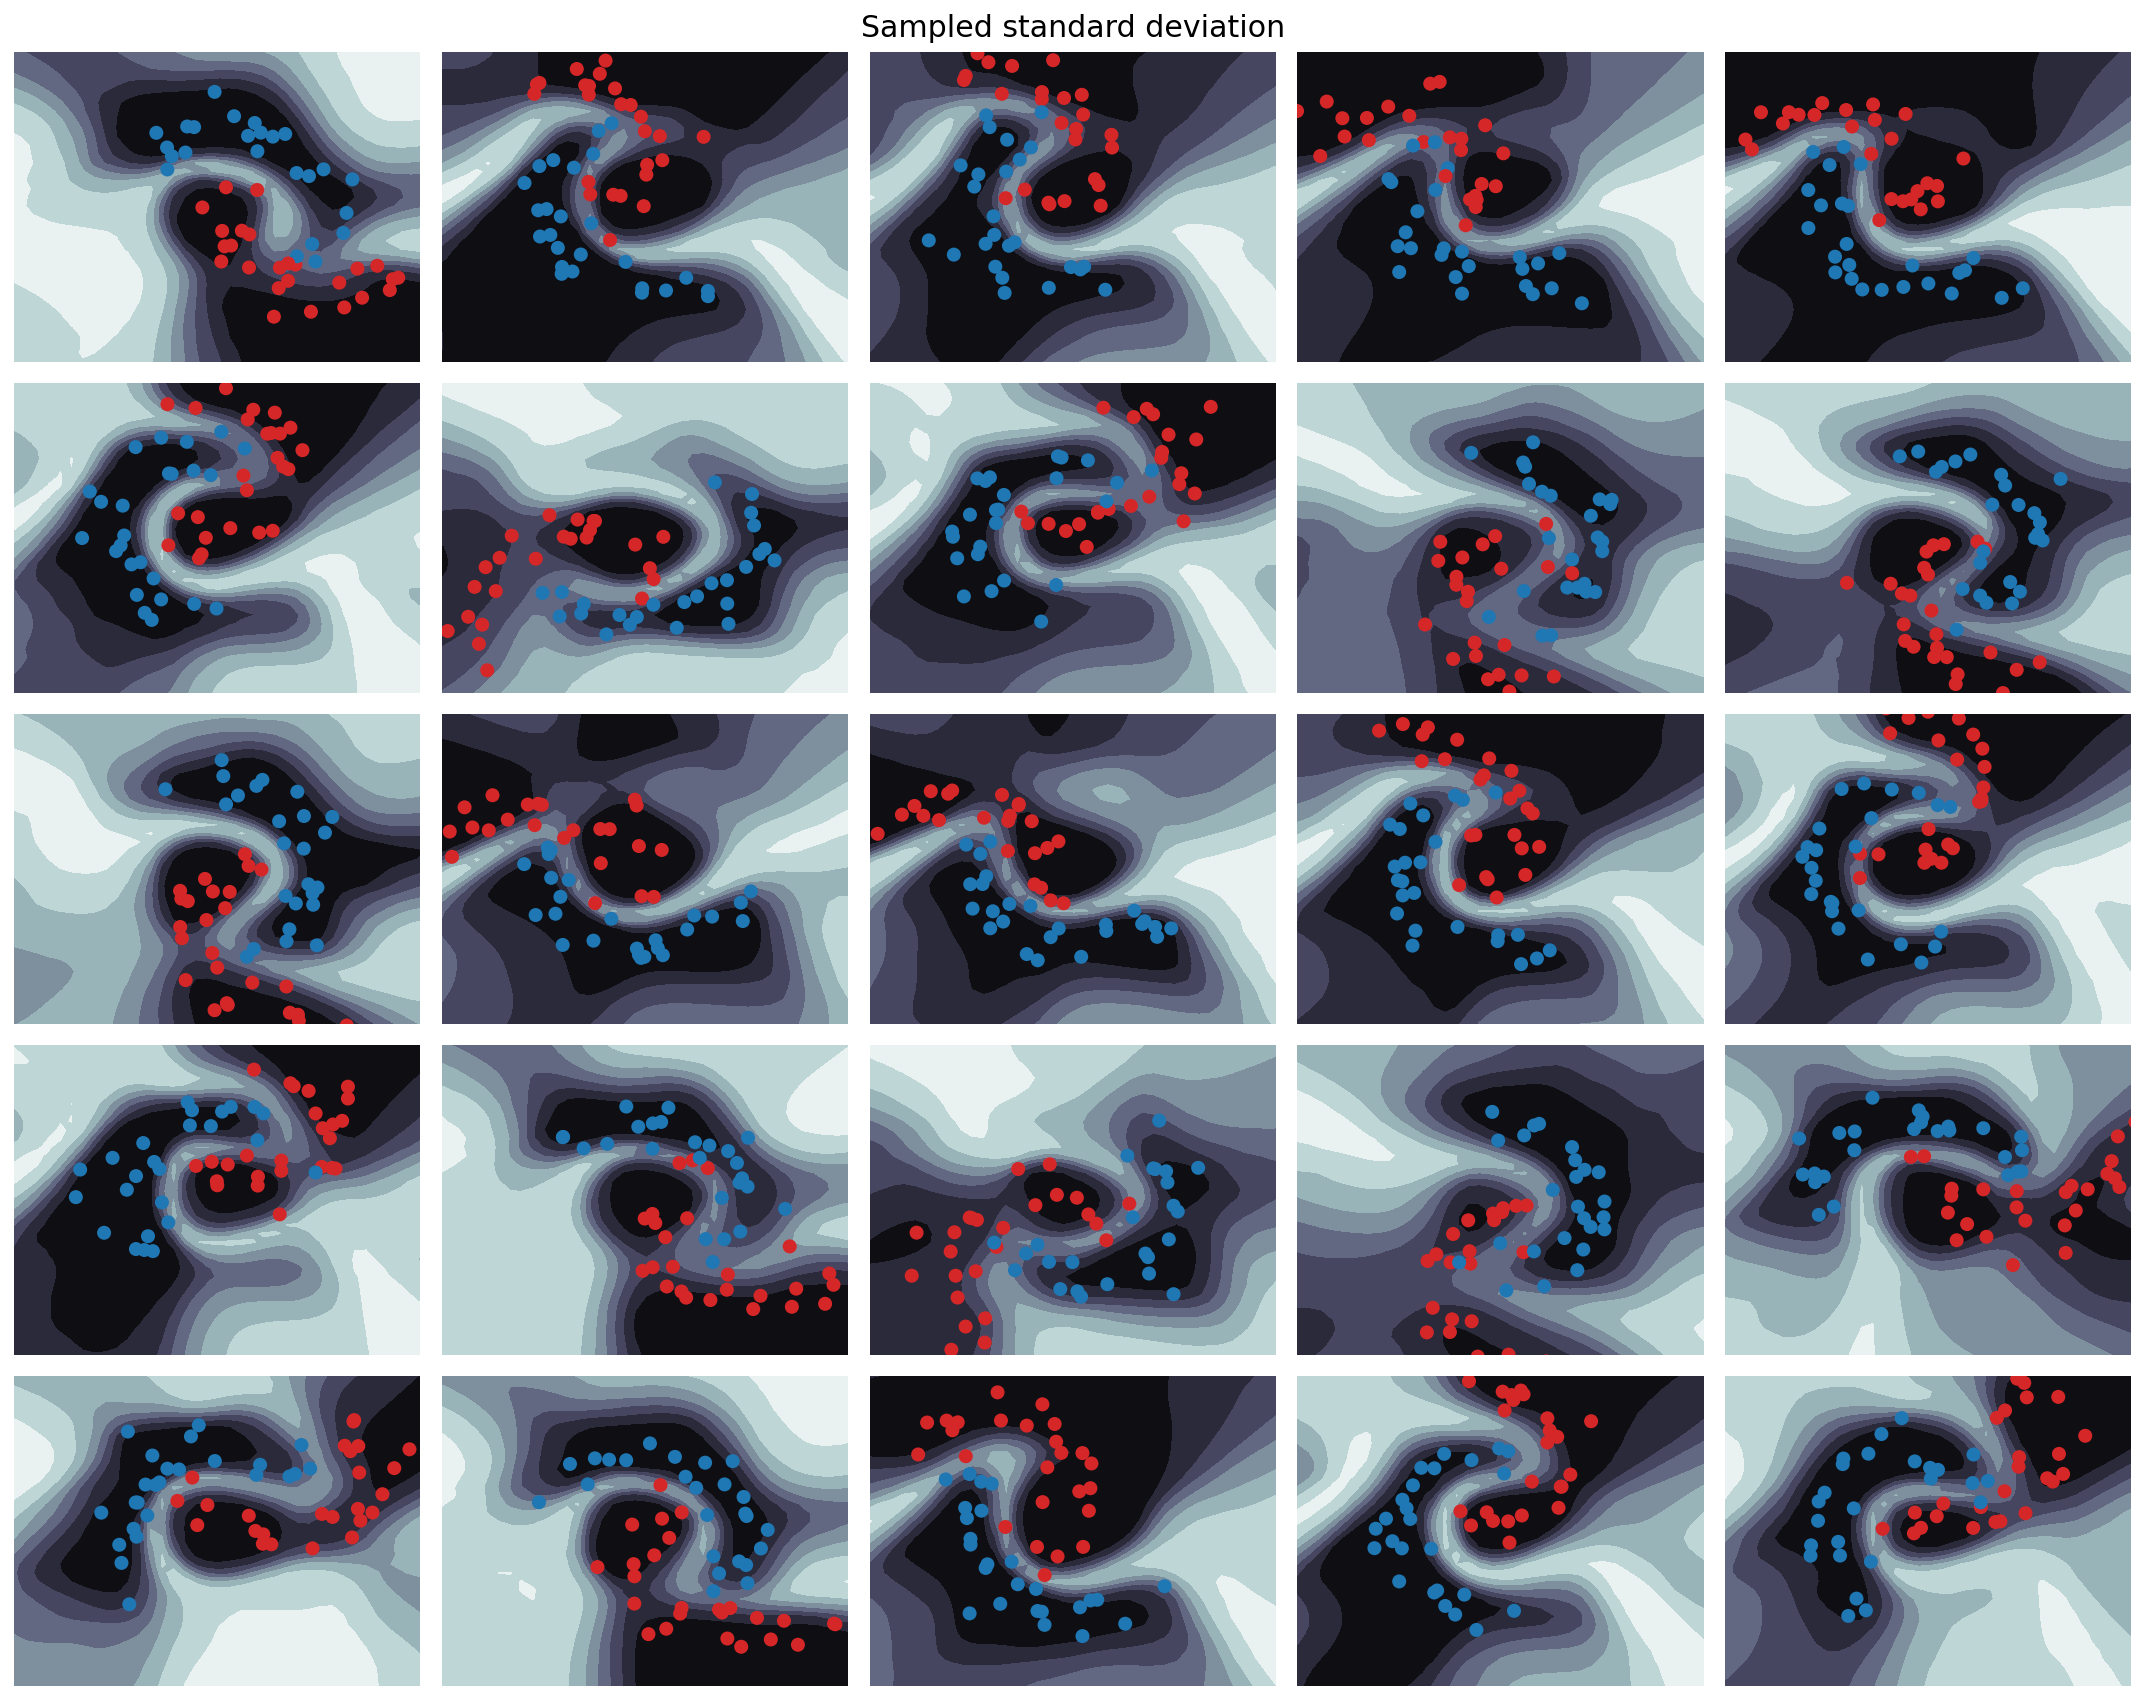

In [36]:
fig, ax = plt.subplots(5, 5, figsize=(15, 12))
for axi, pv, X, y in zip(ax.ravel(), probs_grid_std, X_collection, y_collection):
    colors = ["tab:red" if yn == 1 else "tab:blue" for yn in y]
    axi.contourf(*X_grid, pv, zorder=0, cmap="bone")
    axi.scatter(*X.T, c=colors, zorder=1)
    axi.axis("off")
    axi.set_xlim(-2, 2)
    axi.set_ylim(-2, 2)
plt.suptitle("Sampled standard deviation", fontsize=15)
plt.tight_layout()